# Setting

In [1]:
import os
import gc
import random
import joblib
import pickle
from typing import List, Dict, Union

import numpy as np
from numba import njit
import polars as pl
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.metrics import map_at_k, ap_at_k

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
EXP_NAME = "exp209"
INPUT_DIR = "../../input/raw/"
CANDIDATES_DIR = "candidates/"
FEATURE_DIR = "features/"
LAST_NS = [1, 2, 3]
K_FOLDS = 5
SEED = 42

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(SEED)

In [4]:
LGBM_PARAMS = {
    "objective": "lambdarank",
    "metric": "map",
    "boosting": "dart",
    "seed": SEED,
    "num_leaves": 13,
    "max_depth": 7,
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "eval_at": [20],
    # "lambdarank_truncation_level" : 40,
    "deterministic":True,
}

In [5]:
train_log = pl.read_csv(os.path.join(INPUT_DIR, "train_log.csv"))
train_label = pl.read_csv(os.path.join(INPUT_DIR, "train_label.csv"))
test_log = pl.read_csv(os.path.join(INPUT_DIR, "test_log.csv"))
test_session = pl.read_csv(os.path.join(INPUT_DIR, "test_session.csv"))

In [6]:
co_visit_matrix_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "co_visit_matrix_for_train_or_eval.parquet"))
co_visit_matrix_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "co_visit_matrix_for_test.parquet"))

co_visit_matrix_trend_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "co_visit_matrix_trend_for_train_or_eval.parquet"))
co_visit_matrix_trend_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "co_visit_matrix_trend_for_test.parquet"))

two_hop_co_visit_matrix_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "two_hop_co_visit_matrix_for_train_or_eval.parquet"))
two_hop_co_visit_matrix_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "two_hop_co_visit_matrix_for_test.parquet"))

two_hop_co_visit_matrix_trend_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_two_hop_co_visit_matrix_for_train_or_eval.parquet"))
two_hop_co_visit_matrix_trend_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_two_hop_co_visit_matrix_for_test.parquet"))

already_clicked_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "already_clicked_for_train_or_eval.parquet"))
already_clicked_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "already_clicked_for_test.parquet"))

popular_yados_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_per_sml_cd_for_train_or_eval.parquet"))
popular_yados_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_per_sml_cd_for_test.parquet"))

popular_yados_trend_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_trend_per_sml_cd_for_train_or_eval.parquet"))
popular_yados_trend_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_trend_per_sml_cd_for_test.parquet"))

popular_yados_lrg_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_per_lrg_cd_for_train_or_eval.parquet"))
popular_yados_lrg_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "popular_yados_per_lrg_cd_for_test.parquet"))

popular_yados_trend_lrg_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_popular_yados_per_lrg_cd_for_train_or_eval.parquet"))
popular_yados_trend_lrg_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_popular_yados_per_lrg_cd_for_test.parquet"))

similar_yados = pl.read_parquet(os.path.join(CANDIDATES_DIR, "similar_yados.parquet"))

imf_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "imf_for_train_or_eval.parquet"))
imf_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "imf_for_test.parquet"))

trend_imf_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_imf_for_train_or_eval.parquet"))
trend_imf_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_imf_for_test.parquet"))

bpr_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "bpr_for_train_or_eval.parquet"))
bpr_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "bpr_for_test.parquet"))

trend_bpr_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_bpr_for_train_or_eval.parquet"))
trend_bpr_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "trend_bpr_for_test.parquet"))

i2v_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "item2vec_for_train_or_eval.parquet"))
i2v_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "item2vec_for_test.parquet"))

prone_train = pl.read_parquet(os.path.join(CANDIDATES_DIR, "prone_for_train_or_eval.parquet"))
prone_test = pl.read_parquet(os.path.join(CANDIDATES_DIR, "prone_for_test.parquet"))

In [7]:
class CandidateMatrix:
    def __init__(self, matrix: pl.DataFrame, feat_name: List[str], join_key: str):
        self.matrix = matrix
        self.feat_name = feat_name
        self.join_key = join_key

In [8]:
candidate_matrices_train =[
    CandidateMatrix(co_visit_matrix_train, ["co_visit_weight_rank"], "item"),
    CandidateMatrix(co_visit_matrix_trend_train, ["trend_co_visit_weight_rank"], "item"),
    CandidateMatrix(two_hop_co_visit_matrix_train, ["two_hop_co_visit_weight_rank"], "item"),
    CandidateMatrix(two_hop_co_visit_matrix_trend_train, ["trend_two_hop_co_visit_weight_rank"], "item"),
    CandidateMatrix(already_clicked_train, ["seq_no_inverse"], "session"),
    CandidateMatrix(popular_yados_train, ["popularity_rank"], "item"),
    CandidateMatrix(popular_yados_trend_train, ["trend_popularity_rank"], "item"),
    CandidateMatrix(popular_yados_lrg_train, ["popularity_rank_lrg"], "item"),
    CandidateMatrix(popular_yados_trend_lrg_train, ["trend_popularity_rank_lrg"], "item"),
    CandidateMatrix(similar_yados, ["nn_distance"], "item"),
    CandidateMatrix(imf_train, ["imf_rank"], "session"),
    CandidateMatrix(trend_imf_train, ["trend_imf_rank"], "session"),
    CandidateMatrix(bpr_train, ["bpr_rank"], "session"),
    CandidateMatrix(trend_bpr_train, ["trend_bpr_rank"], "session"),
    CandidateMatrix(i2v_train, ["i2v_rank"], "item"),
    CandidateMatrix(prone_train, ["prone_rank"], "item"),
]

In [9]:
candidate_matrices_test =[
    CandidateMatrix(co_visit_matrix_test, ["co_visit_weight_rank"], "item"),
    CandidateMatrix(co_visit_matrix_trend_test, ["trend_co_visit_weight_rank"], "item"),
    CandidateMatrix(two_hop_co_visit_matrix_test, ["two_hop_co_visit_weight_rank"], "item"),
    CandidateMatrix(two_hop_co_visit_matrix_trend_test, ["trend_two_hop_co_visit_weight_rank"], "item"),
    CandidateMatrix(already_clicked_test, ["seq_no_inverse"], "session"),
    CandidateMatrix(popular_yados_test, ["popularity_rank"], "item"),
    CandidateMatrix(popular_yados_trend_test, ["trend_popularity_rank"], "item"),
    CandidateMatrix(popular_yados_lrg_test, ["popularity_rank_lrg"], "item"),
    CandidateMatrix(popular_yados_trend_lrg_test, ["trend_popularity_rank_lrg"], "item"),
    CandidateMatrix(similar_yados, ["nn_distance"], "item"),
    CandidateMatrix(imf_test, ["imf_rank"], "session"),
    CandidateMatrix(trend_imf_test, ["trend_imf_rank"], "session"),
    CandidateMatrix(bpr_test, ["bpr_rank"], "session"),
    CandidateMatrix(trend_bpr_test, ["trend_bpr_rank"], "session"),
    CandidateMatrix(i2v_test, ["i2v_rank"], "item"),
    CandidateMatrix(prone_test, ["prone_rank"], "item"),
]

In [10]:
session_feat_train = pl.read_parquet(os.path.join(FEATURE_DIR, "session_feat_for_train_or_eval.parquet"))
session_feat_test = pl.read_parquet(os.path.join(FEATURE_DIR, "session_feat_for_test.parquet"))
product_feat_train = pl.read_parquet(os.path.join(FEATURE_DIR, "product_feat_train.parquet"))
product_feat_test = pl.read_parquet(os.path.join(FEATURE_DIR, "product_feat_test.parquet"))
session_product_feat_train = pl.read_parquet(os.path.join(FEATURE_DIR, "session_product_feat_for_train_or_eval.parquet"))
session_product_feat_test = pl.read_parquet(os.path.join(FEATURE_DIR, "session_product_feat_for_test.parquet"))
cf_feat_train = pl.read_parquet(os.path.join(FEATURE_DIR, "cf_feat_for_train_or_eval.parquet"))
cf_feat_test = pl.read_parquet(os.path.join(FEATURE_DIR, "cf_feat_for_test.parquet"))

In [11]:
# i2v
i2v_model_train = Word2Vec.load(os.path.join(FEATURE_DIR, "item2vec_for_train_or_eval.model"))
i2v_model_test = Word2Vec.load(os.path.join(FEATURE_DIR, "item2vec_for_test.model"))

In [12]:
# imf
imf_model_train = np.load(os.path.join(FEATURE_DIR, "imf_model_for_train_or_eval.npz"))
with open(os.path.join(FEATURE_DIR, "imf_user_id2index_for_train_or_eval.pickle"), "rb") as f:
    user_id2index_train = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "imf_item_id2index_for_train_or_eval.pickle"), "rb") as f:
    item_id2index_train = pickle.load(f)

imf_model_test = np.load(os.path.join(FEATURE_DIR, "imf_model_for_test.npz"))
with open(os.path.join(FEATURE_DIR, "imf_user_id2index_for_test.pickle"), "rb") as f:
    user_id2index_test = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "imf_item_id2index_for_test.pickle"), "rb") as f:
    item_id2index_test = pickle.load(f)

trend_imf_model_train = np.load(os.path.join(FEATURE_DIR, "trend_imf_model_for_train_or_eval.npz"))
with open(os.path.join(FEATURE_DIR, "trend_imf_user_id2index_for_train_or_eval.pickle"), "rb") as f:
    trend_user_id2index_train = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "trend_imf_item_id2index_for_train_or_eval.pickle"), "rb") as f:
    trend_item_id2index_train = pickle.load(f)

trend_imf_model_test = np.load(os.path.join(FEATURE_DIR, "trend_imf_model_for_test.npz"))
with open(os.path.join(FEATURE_DIR, "trend_imf_user_id2index_for_test.pickle"), "rb") as f:
    trend_user_id2index_test = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "trend_imf_item_id2index_for_test.pickle"), "rb") as f:
    trend_item_id2index_test = pickle.load(f)

In [13]:
# bpr
bpr_model_train = np.load(os.path.join(FEATURE_DIR, "bpr_model_for_train_or_eval.npz"))
with open(os.path.join(FEATURE_DIR, "bpr_user_id2index_for_train_or_eval.pickle"), "rb") as f:
    bpr_user_id2index_train = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "bpr_item_id2index_for_train_or_eval.pickle"), "rb") as f:
    bpr_item_id2index_train = pickle.load(f)

bpr_model_test = np.load(os.path.join(FEATURE_DIR, "bpr_model_for_test.npz"))
with open(os.path.join(FEATURE_DIR, "bpr_user_id2index_for_test.pickle"), "rb") as f:
    bpr_user_id2index_test = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "bpr_item_id2index_for_test.pickle"), "rb") as f:
    bpr_item_id2index_test = pickle.load(f)

trend_bpr_model_train = np.load(os.path.join(FEATURE_DIR, "trend_bpr_model_for_train_or_eval.npz"))
with open(os.path.join(FEATURE_DIR, "trend_bpr_user_id2index_for_train_or_eval.pickle"), "rb") as f:
    trend_bpr_user_id2index_train = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "trend_bpr_item_id2index_for_train_or_eval.pickle"), "rb") as f:
    trend_bpr_item_id2index_train = pickle.load(f)

trend_bpr_model_test = np.load(os.path.join(FEATURE_DIR, "trend_bpr_model_for_test.npz"))
with open(os.path.join(FEATURE_DIR, "trend_bpr_user_id2index_for_test.pickle"), "rb") as f:
    trend_bpr_user_id2index_test = pickle.load(f)
with open(os.path.join(FEATURE_DIR, "trend_bpr_item_id2index_for_test.pickle"), "rb") as f:
    trend_bpr_item_id2index_test = pickle.load(f)

In [14]:
# proNE
graph_embs_train = np.load(os.path.join(FEATURE_DIR, "graph_embedding_for_train_or_eval.npy"))
with open(os.path.join(FEATURE_DIR, "graph_item_id2index_for_train_or_eval.pickle"), "rb") as f:
    item_id2indices_prone_train = pickle.load(f)

graph_embs_test = np.load(os.path.join(FEATURE_DIR, "graph_embedding_for_test.npy"))
with open(os.path.join(FEATURE_DIR, "graph_item_id2index_for_test.pickle"), "rb") as f:
    item_id2indices_prone_test = pickle.load(f)

In [15]:
def generate_candidates(df: pl.DataFrame, candidate_matrices:List[CandidateMatrix]) -> pl.DataFrame:

    def add_last_n_item(df: pl.DataFrame, last_n: int) -> pl.DataFrame:
        last_item_list = []
        prev_items_list = df["prev_items"].to_list()
        for prev_items in prev_items_list:
            try:
                last_item_list.append(prev_items[-last_n])
            except IndexError:
                last_item_list.append(None)
        df = df.with_columns(pl.Series(name=f"last_yad_no_{last_n}", values=last_item_list))
        return df

    # add last_item columns
    for last_n in LAST_NS:
        df = add_last_n_item(df, last_n)

    # generate candidates
    candidates = []

    # candidates tied to items
    for last_n in LAST_NS:
        for candidate_matrix in candidate_matrices:
            if candidate_matrix.join_key == "item":        
                # join candidates to last_n item
                candidate = df.join(candidate_matrix.matrix, left_on=f"last_yad_no_{last_n}", right_on="yad_no", how="left")
                candidate = candidate.filter(pl.col("last_yad_no_1") != pl.col("candidate_yad_no")) # remove last click yado
                
                # keep candidates for feature addition later
                features_original = candidate_matrix.feat_name
                features = [f"{x}_last{last_n}" for x in features_original]
                tmp = candidate[["session_id", "candidate_yad_no"] + features_original]
                for feature, feature_original in zip(features, features_original):
                    tmp = tmp.rename({feature_original:feature})
                candidates.append(tmp)

    # candidates tied to session
    for candidate_matrix in candidate_matrices:
        if candidate_matrix.join_key == "session":
            candidate = df.join(candidate_matrix.matrix, on="session_id", how="left")
            candidate = candidate.filter(pl.col("last_yad_no_1") != pl.col("candidate_yad_no")) # remove last click yado
            candidates.append(candidate[["session_id", "candidate_yad_no"] + candidate_matrix.feat_name])

    # concatenate candidates
    cand_all = pl.concat([df[["session_id", "candidate_yad_no"]] for df in candidates])

    # remove duplicate candidates
    cand_all = cand_all.unique(subset=["session_id", "candidate_yad_no"])

    # join candidates
    df = df.join(cand_all, on=["session_id"], how="left")

    # add features derived from the candidate
    for candidate in candidates:
        df = df.join(candidate, on=["session_id", "candidate_yad_no"], how="left")

    return df

In [16]:
def add_label(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns((pl.col("candidate_yad_no") == pl.col("label")).cast(pl.Int8).alias("label"))
    return df

In [17]:
def filter_null(df: pl.DataFrame, candidate_matrices:List[CandidateMatrix]) -> pl.DataFrame:
    feat_names = []
    for candidate_matrix in candidate_matrices:
        if candidate_matrix.join_key == "item":
            for last_n in LAST_NS:
                for feat_name in candidate_matrix.feat_name:
                    feat_names.append(f"{feat_name}_last{last_n}")
        elif candidate_matrix.join_key == "session":
            feat_names.extend(candidate_matrix.feat_name)
    
    df = df.filter(
        ~pl.all_horizontal(pl.col(feat_names).is_null())
    )
    
    return df

In [18]:
def filter_session_not_include_positive(df: pl.DataFrame) -> pl.DataFrame:
    positive_sessions = df.filter(pl.col("label")==1)["session_id"].to_list()
    df = df.filter(df["session_id"].is_in(positive_sessions))
    return df

In [19]:
def negative_sample(df: pl.DataFrame) -> pl.DataFrame:
    negatives = df.filter(df["label"] == 0)
    negatives = negatives.sample(fraction=0.075, seed=SEED)
    df = pl.concat([df.filter(df["label"] > 0), negatives])
    return df

In [20]:
def add_features(
    df: pl.DataFrame, 
    session_feat_df:pl.DataFrame, product_feat_df:pl.DataFrame, session_product_feat_df:pl.DataFrame, cf_feat_df:pl.DataFrame,
    i2v_model,
    imf_model, user_id2index, item_id2index,
    bpr_model, bpr_user_id2index, bpr_item_id2index,
    trend_imf_model, trend_user_id2index, trend_item_id2index,
    graph_embs, item_id2indices_prone
) -> pl.DataFrame:

    ### cf features
    for last_n in LAST_NS:
        df = df.join(
            cf_feat_df,
            left_on = [f"last_yad_no_{last_n}", "candidate_yad_no"],
            right_on = ["yad_no", "yad_no_right"],
            how = "left"
        ).rename({
            "lift" : f"lift_last_{last_n}",
            "trend_lift" : f"trend_lift_last_{last_n}",
        })
    
    ### session features
    df = df.join(session_feat_df, on="session_id", how="left")

    ### product features
    df = df.join(product_feat_df, left_on="candidate_yad_no", right_on="yad_no", how="left")

    ### session * product features
    df = df.join(session_product_feat_df, left_on=["session_id", "candidate_yad_no"], right_on=["session_id", "yad_no"], how="left")

    # item2item similality
    for last_n in LAST_NS:
        df = df.with_columns([
            ((pl.col("P_wireless_lan_flg") == pl.col(f"S_wireless_lan_flg_last{last_n}"))&(pl.col(f"S_wireless_lan_flg_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_lan_flg_last{last_n}"),
            ((pl.col("P_onsen_flg") == pl.col(f"S_onsen_flg_last{last_n}"))&(pl.col(f"S_onsen_flg_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_onsen_flg_last{last_n}"),
            ((pl.col("P_kd_stn_5min") == pl.col(f"S_kd_stn_5min_last{last_n}"))&(pl.col(f"S_kd_stn_5min_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_kd_stn_5min_last{last_n}"),
            ((pl.col("P_kd_bch_5min") == pl.col(f"S_kd_bch_5min_last{last_n}"))&(pl.col(f"S_kd_bch_5min_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_kd_bch_5min_last{last_n}"),
            ((pl.col("P_kd_slp_5min") == pl.col(f"S_kd_slp_5min_last{last_n}"))&(pl.col(f"S_kd_slp_5min_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_kd_slp_5min_last{last_n}"),
            ((pl.col("P_kd_conv_walk_5min") == pl.col(f"S_kd_conv_walk_5min_last{last_n}"))&(pl.col(f"S_kd_conv_walk_5min_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_kd_conv_walk_5min_last{last_n}"),
            ((pl.col("P_wid_cd") == pl.col(f"S_wid_cd_last{last_n}"))&(pl.col(f"S_wid_cd_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_wid_cd_last{last_n}"),
            ((pl.col("P_ken_cd") == pl.col(f"S_ken_cd_last{last_n}"))&(pl.col(f"S_ken_cd_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_ken_cd_last{last_n}"),
            ((pl.col("P_lrg_cd") == pl.col(f"S_lrg_cd_last{last_n}"))&(pl.col(f"S_lrg_cd_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_lrg_cd_last{last_n}"),
            ((pl.col("P_sml_cd") == pl.col(f"S_sml_cd_last{last_n}"))&(pl.col(f"S_sml_cd_last{last_n}").is_not_null())).cast(pl.UInt8).alias(f"SP_same_sml_cd_last{last_n}"),
        ])

    for last_n in LAST_NS:
        df = df.with_columns(
            pl.sum_horizontal(
                f"SP_same_lan_flg_last{last_n}", 
                f"SP_same_onsen_flg_last{last_n}", 
                f"SP_same_kd_stn_5min_last{last_n}", 
                f"SP_same_kd_bch_5min_last{last_n}", 
                f"SP_same_kd_slp_5min_last{last_n}", 
                f"SP_same_kd_conv_walk_5min_last{last_n}", 
                f"SP_same_wid_cd_last{last_n}", 
                f"SP_same_ken_cd_last{last_n}", 
                f"SP_same_lan_flg_last{last_n}", 
                f"SP_same_lrg_cd_last{last_n}", 
            )
            .alias(f"SP_item2item_similarity_last{last_n}")
        )
    df = df.with_columns(
        df[[f"SP_item2item_similarity_last{last_n}" for last_n in LAST_NS]].mean(axis=1).alias(f"SP_item2item_similarity")
    )
    df = df.with_columns(
        (pl.col("P_total_room_cnt") - pl.col("S_mean_room_cnt")).alias("SP_diff_room_cnt")
    )

    # i2v similarity
    for last_n in LAST_NS:
        last_items = df[f"last_yad_no_{last_n}"].to_list()
        cand_items = df["candidate_yad_no"].to_list()
        item_similalities = []
        for last_item, cand_item in zip(last_items, cand_items):
            try:
                sim = i2v_model.wv.similarity(last_item, cand_item)
            except (KeyError, TypeError): # KeyError if the item is not in the item2vec training data. TypeError if there are no candidates in a session.
                sim = -1
            item_similalities.append(np.float32(sim))
        df = df.with_columns(pl.Series(name=f"i2v_similarity_last{last_n}", values=item_similalities).cast(pl.Float32))
    df = df.with_columns(
        (pl.col("i2v_similarity_last1") + pl.col("i2v_similarity_last2") + pl.col("i2v_similarity_last3")) \
        .mean() \
        .alias("i2v_similarity_mean")
    )

    @njit()
    def calc_cos_sim(v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    # prone similarity between last items and candidates
    for last_n in LAST_NS:
        last_items = df[f"last_yad_no_{last_n}"].to_list()
        cand_items = df["candidate_yad_no"].to_list()
        item_similalities = []
        item_index2vector = dict(enumerate(graph_embs))
        for last_item, cand_item in zip(last_items, cand_items):
            try:
                item_index1 = item_id2indices_prone[last_item]
                item_index2 = item_id2indices_prone[cand_item]
                v1, v2 = item_index2vector[item_index1], item_index2vector[item_index2]
                sim = calc_cos_sim(v1, v2)
            except (KeyError, TypeError): # KeyError if the item is not in the item2vec training data. TypeError if there are no candidates in a session.
                sim = -1
            item_similalities.append(np.float32(sim))
        df = df.with_columns(pl.Series(name=f"graph_emb_similarity_last{last_n}", values=item_similalities).cast(pl.Float32))

    # session2item similarity

    sessions = df["session_id"].to_list()
    candidates = df["candidate_yad_no"].to_list()
    user_index2vector = dict(enumerate(imf_model["user_factors"]))
    item_index2vector = dict(enumerate(imf_model["item_factors"]))
    imf_similarities = []
    for session, candidate in zip(sessions, candidates):
        try:
            user_index, item_index = user_id2index[session], item_id2index[candidate]
            v1, v2 = user_index2vector[user_index], item_index2vector[item_index]
            sim = calc_cos_sim(v1, v2)
        except (KeyError, TypeError): # KeyError if the item is not in the imf training data. TypeError if there are no candidates in a session.
            sim = -1
        imf_similarities.append(np.float32(sim))
    df = df.with_columns(pl.Series(name="imf_similarity", values=imf_similarities).cast(pl.Float32))

    sessions = df["session_id"].to_list()
    candidates = df["candidate_yad_no"].to_list()
    user_index2vector = dict(enumerate(trend_imf_model["user_factors"]))
    item_index2vector = dict(enumerate(trend_imf_model["item_factors"]))
    imf_similarities = []
    for session, candidate in zip(sessions, candidates):
        try:
            user_index, item_index = trend_user_id2index[session], trend_item_id2index[candidate]
            v1, v2 = user_index2vector[user_index], item_index2vector[item_index]
            sim = calc_cos_sim(v1, v2)
        except (KeyError, TypeError): # KeyError if the item is not in the imf training data. TypeError if there are no candidates in a session.
            sim = -1
        imf_similarities.append(np.float32(sim))
    df = df.with_columns(pl.Series(name="trend_imf_similarity", values=imf_similarities).cast(pl.Float32))

    # bpr
    sessions = df["session_id"].to_list()
    candidates = df["candidate_yad_no"].to_list()
    user_index2vector = dict(enumerate(bpr_model["user_factors"]))
    item_index2vector = dict(enumerate(bpr_model["item_factors"]))
    imf_similarities = []
    for session, candidate in zip(sessions, candidates):
        try:
            user_index, item_index = bpr_user_id2index[session], bpr_item_id2index[candidate]
            v1, v2 = user_index2vector[user_index], item_index2vector[item_index]
            sim = calc_cos_sim(v1, v2)
        except (KeyError, TypeError): # KeyError if the item is not in the imf training data. TypeError if there are no candidates in a session.
            sim = -1
        imf_similarities.append(np.float32(sim))
    df = df.with_columns(pl.Series(name="bpr_similarity", values=imf_similarities).cast(pl.Float32))

    return df

In [21]:
def fill_null_and_cast(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns([
        pl.col("co_visit_weight_rank_last1").fill_null(-1).cast(pl.Float32),
        pl.col("co_visit_weight_rank_last2").fill_null(-1).cast(pl.Float32),
        pl.col("co_visit_weight_rank_last3").fill_null(-1).cast(pl.Float32),
        pl.col("trend_co_visit_weight_rank_last1").fill_null(-1).cast(pl.Float32),
        pl.col("trend_co_visit_weight_rank_last2").fill_null(-1).cast(pl.Float32),
        pl.col("trend_co_visit_weight_rank_last3").fill_null(-1).cast(pl.Float32),
        pl.col("two_hop_co_visit_weight_rank_last1").fill_null(-1).cast(pl.Float32),
        pl.col("two_hop_co_visit_weight_rank_last2").fill_null(-1).cast(pl.Float32),
        pl.col("two_hop_co_visit_weight_rank_last3").fill_null(-1).cast(pl.Float32),
        pl.col("popularity_rank_last1").fill_null(-1).cast(pl.Float32),
        pl.col("popularity_rank_last2").fill_null(-1).cast(pl.Float32),
        pl.col("popularity_rank_last3").fill_null(-1).cast(pl.Float32),
        pl.col("trend_popularity_rank_last1").fill_null(-1).cast(pl.Float32),
        pl.col("trend_popularity_rank_last2").fill_null(-1).cast(pl.Float32),
        pl.col("trend_popularity_rank_last3").fill_null(-1).cast(pl.Float32),
        pl.col("popularity_rank_lrg_last1").fill_null(-1).cast(pl.Float32),
        pl.col("popularity_rank_lrg_last2").fill_null(-1).cast(pl.Float32),
        pl.col("popularity_rank_lrg_last3").fill_null(-1).cast(pl.Float32),
        pl.col("trend_popularity_rank_lrg_last1").fill_null(-1).cast(pl.Float32),
        pl.col("trend_popularity_rank_lrg_last2").fill_null(-1).cast(pl.Float32),
        pl.col("trend_popularity_rank_lrg_last3").fill_null(-1).cast(pl.Float32),
        pl.col("nn_distance_last1").fill_null(999).cast(pl.Float32),
        pl.col("nn_distance_last2").fill_null(999).cast(pl.Float32),
        pl.col("nn_distance_last3").fill_null(999).cast(pl.Float32),
        pl.col("i2v_rank_last1").fill_null(-1).cast(pl.Float32),
        pl.col("i2v_rank_last2").fill_null(-1).cast(pl.Float32),
        pl.col("i2v_rank_last3").fill_null(-1).cast(pl.Float32),
        pl.col("prone_rank_last1").fill_null(-1).cast(pl.Float32),
        pl.col("prone_rank_last2").fill_null(-1).cast(pl.Float32),
        pl.col("prone_rank_last3").fill_null(-1).cast(pl.Float32),
        pl.col("seq_no_inverse").fill_null(999).cast(pl.Int16),
        pl.col("imf_rank").fill_null(-1).cast(pl.Float32),
        pl.col("trend_imf_rank").fill_null(-1).cast(pl.Float32),
        pl.col("bpr_rank").fill_null(-1).cast(pl.Float32),
        pl.col("SP_interact_count").fill_null(0).cast(pl.Int16),
    ])
    return df

In [22]:
def predict(df:pl.DataFrame, chunk_size:int=30_000_000) -> np.array:
    preds = np.zeros((df.shape[0],))
    for fold in range(K_FOLDS):
        # load model
        model = pickle.load(open(f'../../model/lgb_{EXP_NAME}_{fold+1}.pkl', "rb"))
        # chunk data and predict to prevent OOM
        preds_by_one_model = []
        for frame in df.iter_slices(n_rows=chunk_size):
            preds_chunk = model.predict(frame[FEATURES].to_pandas(), num_iteration=model.best_iteration)
            preds_by_one_model.append(preds_chunk)
        preds += np.concatenate(preds_by_one_model)
    preds /= K_FOLDS
    return preds

# Process train data

In [23]:
original_train_log = train_log.clone()
original_train_label = train_label.clone()

In [24]:
prev_items_list = (
    train_log
    .sort(["session_id", "seq_no"])
    .group_by("session_id", maintain_order=True)
    .agg(pl.col("yad_no"))
)["yad_no"].to_list()

train = train_label.with_columns(
    pl.Series(name="prev_items", values=prev_items_list)
).rename(
    {"yad_no":"label"}
)

In [25]:
train = generate_candidates(train, candidate_matrices_train)
train = train.drop("prev_items")
train = add_label(train)
train = filter_null(train, candidate_matrices_train)
train = filter_session_not_include_positive(train)
train = negative_sample(train)
train = add_features(
    train, 
    session_feat_train, product_feat_train, session_product_feat_train, cf_feat_train,
    i2v_model_train,
    imf_model_train, user_id2index_train, item_id2index_train,
    trend_imf_model_train, trend_user_id2index_train, trend_item_id2index_train,
    bpr_model_train, bpr_user_id2index_train, bpr_item_id2index_train,
    graph_embs_train, item_id2indices_prone_train,
)
train = fill_null_and_cast(train)

/tmp/ipykernel_3637334/1406511015.py:90: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


# Train model

In [26]:
not_use_col = [
    "session_id",
    "label",
    "last_yad_no_1",
    "last_yad_no_2",
    "last_yad_no_3",
    "candidate_yad_no",
    "P_wid_cd", "P_ken_cd", "P_lrg_cd", "P_sml_cd",
    "S_wid_cd_last1", "S_wid_cd_last2", "S_wid_cd_last3",
    "S_ken_cd_last1", "S_ken_cd_last2", "S_ken_cd_last3",
    "S_lrg_cd_last1", "S_lrg_cd_last2", "S_lrg_cd_last3",
    "S_sml_cd_last1", "S_sml_cd_last2", "S_sml_cd_last3",
]
FEATURES = [col for col in train.columns if col not in not_use_col]

In [27]:
train = train[["session_id", "candidate_yad_no", "label"] + FEATURES]

In [28]:
train = train.to_pandas()

In [29]:
# https://qiita.com/birdwatcher/items/78e0158957fec2d6c9e8
class DartEarlyStopping(object):
    """DartEarlyStopping"""

    def __init__(self, data_name, monitor_metric, stopping_round):
        self.data_name = data_name
        self.monitor_metric = monitor_metric
        self.stopping_round = stopping_round
        self.best_score = None
        self.best_model = None
        self.best_score_list = []
        self.best_iter = 0

    def _is_higher_score(self, metric_score, is_higher_better):
        if self.best_score is None:
            return True
        return (self.best_score < metric_score) if is_higher_better else (self.best_score > metric_score)

    def _deepcopy(self, x):
        # copy.deepcopyではlightgbmのモデルは完全にコピーされないためpickleを使用
        return pickle.loads(pickle.dumps(x))

    def __call__(self, env):
        evals = env.evaluation_result_list
        for data, metric, score, is_higher_better in evals:
            if data != self.data_name or metric != self.monitor_metric:
                continue
            if not self._is_higher_score(score, is_higher_better):
                if env.iteration - self.best_iter > self.stopping_round:
                    # 終了させる
                    eval_result_str = '\t'.join([lgb.callback._format_eval_result(x) for x in self.best_score_list])
                    lgb.basic._log_info(f"Early stopping, best iteration is:\n[{self.best_iter+1}]\t{eval_result_str}") 
                    lgb.basic._log_info(f"You can get best model by \"DartEarlyStopping.best_model\"")
                    raise lgb.callback.EarlyStopException(self.best_iter, self.best_score_list)
                return
            # dartでは過去の木も更新されてしまうため、deepcopyしておく
            self.best_model = self._deepcopy(env.model)
            self.best_iter = env.iteration
            self.best_score_list = evals
            self.best_score = score
            return
        raise ValueError("monitoring metric not found")

In [30]:
%%time
feat_imp = np.zeros((len(FEATURES),))
oof_predictions = []
gkf = GroupKFold(n_splits=K_FOLDS)
for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train["label"], groups=train["session_id"])):
    print(f'======= Fold {fold+1}=======')

    # Split data into train and validation sets
    train_tmp = train.iloc[train_idx].copy()
    valid_tmp = train.iloc[val_idx].copy()
    train_tmp.sort_values("session_id", inplace=True)
    valid_tmp.sort_values("session_id", inplace=True)
    train_baskets = train_tmp.groupby("session_id")["candidate_yad_no"].count().values
    valid_baskets = valid_tmp.groupby("session_id")["candidate_yad_no"].count().values
    X_train, y_train = train_tmp[FEATURES], train_tmp["label"]
    X_val, y_val = valid_tmp[FEATURES], valid_tmp["label"]

    # Create LightGBM dataset
    lgb_train = lgb.Dataset(X_train, y_train, group=train_baskets)
    lgb_val = lgb.Dataset(X_val, y_val, group=valid_baskets, reference=lgb_train)

    # Train LightGBM model
    des = DartEarlyStopping("valid_1", "map@20", 100)
    model = lgb.train(LGBM_PARAMS,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=[lgb_train, lgb_val],
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=100),
                        lgb.log_evaluation(25),
                        des,
                    ]
            )
    model = des.best_model
    
    # Save LightGBM model
    joblib.dump(model, f'../../model/lgb_{EXP_NAME}_{fold+1}.pkl')

    # Add feature importance scores
    feat_imp += model.feature_importance(importance_type="gain")

    # Predict oof
    valid_sessions = list(valid_tmp["session_id"].unique())
    valid_log = original_train_log.filter(pl.col("session_id").is_in(valid_sessions))
    valid_label = original_train_label.filter(pl.col("session_id").is_in(valid_sessions))
    
    prev_items_list = (
        valid_log
        .sort(["session_id", "seq_no"])
        .group_by("session_id", maintain_order=True)
        .agg(pl.col("yad_no"))
    )["yad_no"].to_list()
    
    valid = valid_label.with_columns(
        pl.Series(name="prev_items", values=prev_items_list)
    ).rename(
        {"yad_no":"label"}
    )

    valid = generate_candidates(valid, candidate_matrices_train)
    valid = valid.drop("prev_items")
    valid = add_features(
        valid, 
        session_feat_train, product_feat_train, session_product_feat_train, cf_feat_train,
        i2v_model_train,
        imf_model_train, user_id2index_train, item_id2index_train,
        trend_imf_model_train, trend_user_id2index_train, trend_item_id2index_train,
        bpr_model_train, bpr_user_id2index_train, bpr_item_id2index_train,
        graph_embs_train, item_id2indices_prone_train,
    )
    valid = fill_null_and_cast(valid)

    model = pickle.load(open(f'../../model/lgb_{EXP_NAME}_{fold+1}.pkl', "rb"))
    preds = model.predict(valid[FEATURES].to_pandas(), num_iteration=model.best_iteration)
    valid = valid.with_columns(pl.Series(name="pred", values=preds))    
    # valid = valid[["session_id", "candidate_yad_no", "pred", "label"]]
    valid = valid.sort(["session_id", "pred"], descending=[False, True])
    oof_prediction = valid.group_by("session_id", maintain_order=True).head(10)
    oof_predictions.append(oof_prediction)

oof_prediction = pl.concat(oof_predictions)
oof_prediction = oof_prediction.with_columns((pl.col("candidate_yad_no") == pl.col("label")).cast(pl.Int8).alias("user_relevance")).fill_null(0)
user_relevances = oof_prediction.group_by("session_id", maintain_order=True).all()["user_relevance"].to_list()
print(f'======= Training Done =======')
total_num_session = original_train_log["session_id"].n_unique()
print("map@10:", float(np.sum([ap_at_k(user_relevances, 10) for user_relevances in user_relevances]) / total_num_session))
print(f'=============================')

======= Fold 1=======
[LightGBM] [Info] Total groups: 220228, total data: 1633120
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.856976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10436
[LightGBM] [Info] Number of data points in the train set: 1633120, number of used features: 137
[LightGBM] [Info] Total groups: 55057, total data: 408281


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.763596	valid_1's map@20: 0.764321
[50]	training's map@20: 0.764349	valid_1's map@20: 0.765329
[75]	training's map@20: 0.764962	valid_1's map@20: 0.765495
[100]	training's map@20: 0.765437	valid_1's map@20: 0.765737
[125]	training's map@20: 0.765469	valid_1's map@20: 0.765999
[150]	training's map@20: 0.766088	valid_1's map@20: 0.765747
[175]	training's map@20: 0.766177	valid_1's map@20: 0.765852
[200]	training's map@20: 0.766494	valid_1's map@20: 0.765908
[225]	training's map@20: 0.766751	valid_1's map@20: 0.765803
Early stopping, best iteration is:
[130]	training's map@20: 0.765603	valid_1's map@20: 0.766135
You can get best model by "DartEarlyStopping.best_model"
======= Fold 2=======
[LightGBM] [Info] Total groups: 220228, total data: 1633121
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.763846	valid_1's map@20: 0.762791
[50]	training's map@20: 0.764914	valid_1's map@20: 0.763707
[75]	training's map@20: 0.765492	valid_1's map@20: 0.764266
[100]	training's map@20: 0.76581	valid_1's map@20: 0.764497
[125]	training's map@20: 0.765942	valid_1's map@20: 0.764291
[150]	training's map@20: 0.766161	valid_1's map@20: 0.76453
[175]	training's map@20: 0.766251	valid_1's map@20: 0.764612
[200]	training's map@20: 0.766547	valid_1's map@20: 0.764804
[225]	training's map@20: 0.76697	valid_1's map@20: 0.764873
[250]	training's map@20: 0.767211	valid_1's map@20: 0.764973
[275]	training's map@20: 0.767385	valid_1's map@20: 0.765395
[300]	training's map@20: 0.76757	valid_1's map@20: 0.76522
[325]	training's map@20: 0.767773	valid_1's map@20: 0.765044
[350]	training's map@20: 0.7681	valid_1's map@20: 0.765252
[375]	training's map@20: 0.768244	valid_1's map@20: 0.765231
[400]	training's map@20: 0.768544	valid_1's map@20: 0.765235
[425]	training's map@20: 0.768705	

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.763623	valid_1's map@20: 0.763231
[50]	training's map@20: 0.764787	valid_1's map@20: 0.763484
[75]	training's map@20: 0.765482	valid_1's map@20: 0.764156
[100]	training's map@20: 0.765884	valid_1's map@20: 0.764427
[125]	training's map@20: 0.765815	valid_1's map@20: 0.764553
[150]	training's map@20: 0.766084	valid_1's map@20: 0.764653
[175]	training's map@20: 0.766245	valid_1's map@20: 0.764666
[200]	training's map@20: 0.766787	valid_1's map@20: 0.764771
[225]	training's map@20: 0.767014	valid_1's map@20: 0.764628
[250]	training's map@20: 0.76719	valid_1's map@20: 0.764878
[275]	training's map@20: 0.767362	valid_1's map@20: 0.764903
[300]	training's map@20: 0.767714	valid_1's map@20: 0.765066
[325]	training's map@20: 0.768091	valid_1's map@20: 0.764974
[350]	training's map@20: 0.768219	valid_1's map@20: 0.764689
[375]	training's map@20: 0.768288	valid_1's map@20: 0.76484
Early stopping, best iteration is:
[293]	training's map@20: 0.76759	valid_1's map@20: 0.76

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.764101	valid_1's map@20: 0.761016
[50]	training's map@20: 0.765269	valid_1's map@20: 0.762074
[75]	training's map@20: 0.765859	valid_1's map@20: 0.762269
[100]	training's map@20: 0.766322	valid_1's map@20: 0.762738
[125]	training's map@20: 0.766387	valid_1's map@20: 0.762755
[150]	training's map@20: 0.766819	valid_1's map@20: 0.763036
[175]	training's map@20: 0.766885	valid_1's map@20: 0.763188
[200]	training's map@20: 0.76707	valid_1's map@20: 0.763249
[225]	training's map@20: 0.767455	valid_1's map@20: 0.763122
[250]	training's map@20: 0.767661	valid_1's map@20: 0.763319
[275]	training's map@20: 0.768025	valid_1's map@20: 0.763215
[300]	training's map@20: 0.768285	valid_1's map@20: 0.763199
[325]	training's map@20: 0.768427	valid_1's map@20: 0.763033
[350]	training's map@20: 0.768742	valid_1's map@20: 0.762935
Early stopping, best iteration is:
[260]	training's map@20: 0.767929	valid_1's map@20: 0.76359
You can get best model by "DartEarlyStopping.best_model

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[25]	training's map@20: 0.763415	valid_1's map@20: 0.764454
[50]	training's map@20: 0.764698	valid_1's map@20: 0.765022
[75]	training's map@20: 0.765254	valid_1's map@20: 0.76573
[100]	training's map@20: 0.765777	valid_1's map@20: 0.766084
[125]	training's map@20: 0.765748	valid_1's map@20: 0.766008
[150]	training's map@20: 0.766003	valid_1's map@20: 0.766518
[175]	training's map@20: 0.766182	valid_1's map@20: 0.766287
[200]	training's map@20: 0.766349	valid_1's map@20: 0.766372
[225]	training's map@20: 0.766646	valid_1's map@20: 0.766671
[250]	training's map@20: 0.766933	valid_1's map@20: 0.76654
[275]	training's map@20: 0.767002	valid_1's map@20: 0.766637
[300]	training's map@20: 0.767278	valid_1's map@20: 0.766616
[325]	training's map@20: 0.767581	valid_1's map@20: 0.766672
[350]	training's map@20: 0.767775	valid_1's map@20: 0.766733
[375]	training's map@20: 0.767884	valid_1's map@20: 0.76646
[400]	training's map@20: 0.768057	valid_1's map@20: 0.766835
[425]	training's map@20: 0.768

[Text(0.5, 1.0, 'Feature Importance TOP25')]

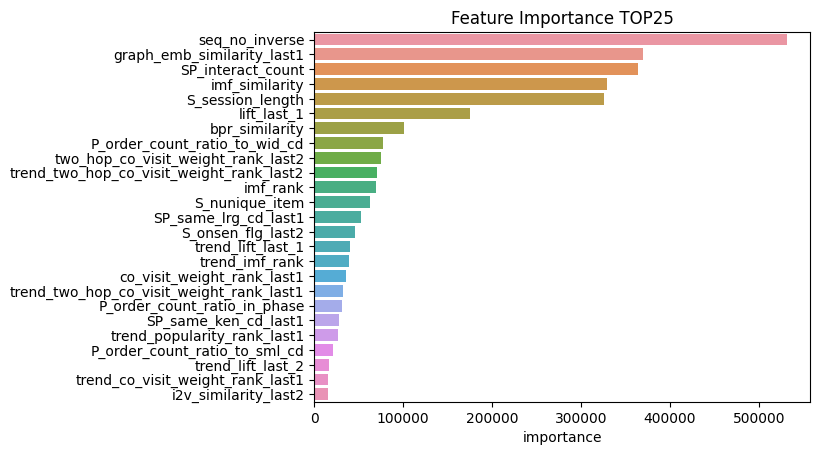

In [31]:
# visualize feature importances
fi_df = pd.DataFrame(index=FEATURES)
fi_df["importance"] = feat_imp / K_FOLDS
fi_df = fi_df.sort_values(by="importance", ascending=False).head(25)
sns.barplot(x="importance", y=fi_df.index, data=fi_df).set(title="Feature Importance TOP25")

# Prediction

In [32]:
prev_items_list = (
    test_log
    .sort(["session_id", "seq_no"])
    .group_by("session_id", maintain_order=True)
    .agg(pl.col("yad_no"))
)["yad_no"].to_list()

test = test_session.with_columns(
    pl.Series(name="prev_items", values=prev_items_list)
)

In [33]:
test = generate_candidates(test, candidate_matrices_test)
test = test.drop("prev_items")
test = add_features(
    test, 
    session_feat_test, product_feat_test, session_product_feat_test, cf_feat_test,
    i2v_model_test,
    imf_model_test, user_id2index_test, item_id2index_test,
    trend_imf_model_test, trend_user_id2index_test, trend_item_id2index_test,
    bpr_model_test, bpr_user_id2index_test, bpr_item_id2index_test,
    graph_embs_test, item_id2indices_prone_test,
)
test = fill_null_and_cast(test)

In [34]:
# prediction

def create_submit_file(pred, test_session, file_name, head_n=10):
    pred = pred.sort(["session_id", "pred"], descending=[False, True])
    prediction = pred.group_by("session_id", maintain_order=True).head(head_n)
    
    col_map = {}
    for i in range(0, head_n):
        col_map[f"{i}"] = f"predict_{i}"   
    prediction = prediction.with_columns(
        prediction.select(pl.col("session_id").cumcount().over("session_id").alias("pred_num"))
    )
    prediction = prediction.pivot(
        index="session_id",
        columns = "pred_num",
        values = "candidate_yad_no",
    ).rename(col_map)
    prediction = test_session.join(prediction, on="session_id", how="left")
    prediction = prediction.fill_null(0)
    prediction.drop("session_id").write_csv(file_name)

test = test.with_columns(
    pl.Series(name="pred", values=predict(test))
)

# for submit
file_name = f"../../output/{EXP_NAME}.csv"
create_submit_file(test, test_session, file_name, 10)

# for ensamble
file_name = f"../../output/{EXP_NAME}_for_ensamble.csv"
create_submit_file(test, test_session, file_name, 15)

# visualize

In [35]:
# cols = FEATURES + ["pred"]

In [36]:
# for col in cols:
#     fig, ax = plt.subplots()

#     x1 = valid[col]
#     x2 = test[col]

#     # 最大値と最小値の間をn_bin等分した幅でヒストグラムの棒を表示するように設定（各targetのbin幅を統一する）
#     n_bin = 20
#     if col.startswith("co_visit_weight"):
#         x_max = 100
#         x_min = 0
#     elif col.startswith("popularity"):
#         x_max = 10
#         x_min = 0
#     elif col == "seq_no_inverse":
#         x_max = 10
#         x_min = 0
#     elif col == "imf_rank":
#         x_max = 10
#         x_min = 0
#     else:
#         x_max = max(valid[col].max(), test[col].max())
#         x_min = min(valid[col].min(), test[col].min())
#     bins = np.linspace(x_min, x_max, n_bin)

#     ax.hist(x1, density=True, bins=bins, color="red", alpha=0.5, label="valid")
#     ax.hist(x2, density=True, bins=bins, color="blue", alpha=0.5, label="test")
#     ax.set_title(col)
#     ax.legend()

#     fig.show()